<a href="https://colab.research.google.com/github/nudro/jean_bartik_LSTM_TCN/blob/master/tutorial_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Making Forecasts with Physiological Sensor Time Series Data</h1>


**Dataset**


Use the PAMAP2 Physical Activity Monitoring Data Set from https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring. This dataset collects a variety of physiological data for each of nine subjects: 

- Heart Rate (BPM)
- Temperature (Deg Celsius)
- 3D Acceleration Data
- 3D Gyroscope Data
- 3D Magnetometer data

Data was collected by subjects who wore three Colibri Wireless Inertial Measurement Units (IMU), one on her hand, one on her chest, and one on her ankle. 

<center><img src="https://est-kl.com/images/products/Trivisio/Trivisio_Colibri_wireless_intro.png"></img></center>



This is also an interesting dataset because it only contains one female subject out of nine total subjects. This particular subject, we'll call her <b>"Jane 102"</b>. 

* 25 yo
* 169 cm
* 78 kg
* Resting HR = 74 bpm
* Max HR = 195 bpm
* Right hand dominant


<img src="https://3dwarehouse.sketchup.com/warehouse/getpubliccontent?contentId=080169c1-8b81-4691-9377-60d9a3867d41"></img>

I've already provided Jane's data file in the Google Drive. So let's first start by setting up this Google Colab notebook and mounting your drive which should have the Jean Bartik Tutorial file folder already copied over to your personal Drive.

<b>Some Google Colab Tips</b>


<b>Change your runtime to GPU</b>, Ref: https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
  
*   Edit > Notebook settings, or

*  Runtime>Change runtime type and select GPU as Hardware accelerator


  <b>Another Tip: How to Clear Outputs of All Cells</b>
* Follow Tools>>Command Palette>>Clear All Outputs

<b>Unfortunately</b>... As of this writing Google simply gives only 5% of GPU to some of us, whereas 100% to the others. https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

#if two commas, that means you're using the CPU!

'/device:GPU:0'

In [0]:
#Check your memory available

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

!cat /proc/meminfo

MemTotal:       13335268 kB
MemFree:         6818132 kB
MemAvailable:   10649888 kB
Buffers:           87832 kB
Cached:          2875024 kB
SwapCached:            0 kB
Active:          2586432 kB
Inactive:        3473152 kB
Active(anon):    2039740 kB
Inactive(anon):     8544 kB
Active(file):     546692 kB
Inactive(file):  3464608 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1100 kB
Writeback:             0 kB
AnonPages:       3096804 kB
Mapped:           630236 kB
Shmem:              9092 kB
Slab:             171856 kB
SReclaimable:     123384 kB
SUnreclaim:        48472 kB
KernelStack:        5408 kB
PageTables:        15608 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667632 kB
Committed_AS:    5769632 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

<b>Mount your Google Drive</b>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Jean Bartik Tutorial"

 1609.03499.pdf
 Build_RNN_Tutorial_Instructions.docx
 keras_causal.png
 log
 lstm_data.png
 model.h5
 mylstm.png
 my_matrix.dat
 my_matrix_y_train.dat
 Petty_03.jpg
 rnn_batch.png
 rnn_numpy.ipynb
 rnnpettynumpy.png
 rnn.png
 rnn_weights.png
 subject101.dat
 subject102.dat
 subject103.dat
 subject104.dat
 subject105.dat
 subject106.dat
 subject107.dat
 subject108.dat
 subject109.dat
 tboard.png
'Text Generation in Keras Tom Petty Lyrics.ipynb'
 timedistributed_lstm.png
 tom_3.hdf5
 tompetty.txt
 tutorial_rnn_lstm.ipynb
 tutorial_wavenet.ipynb
 walkforward.png
 WaveNet_gif.gif
 x_train_sensors
 youtube.png


#Load Data

This might take a few seconds...

In [0]:
import numpy as np
import pandas as pd

In [0]:
df = pd.read_table("/content/drive/My Drive/Jean Bartik Tutorial/subject102.dat", sep="\s+", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,5.64,0,NaN,33.0,2.79143,7.55389,-7.06374,2.87553,7.88823,-6.76139,...,-0.027148,-0.031190,-0.040897,-47.7695,-2.58701,59.8481,-0.012871,0.747947,-0.079841,0.658813
1,5.65,0,NaN,33.0,2.86086,7.43814,-7.21626,2.84248,7.63164,-6.85140,...,0.012803,-0.036384,-0.014846,-47.7624,-2.81438,60.3407,0.014025,-0.748410,0.079043,-0.658360
2,5.66,0,100.0,33.0,2.80997,7.09430,-7.52376,2.79373,7.43545,-7.07744,...,-0.001695,-0.034530,-0.040074,-47.5393,-2.38909,60.9623,0.012714,-0.749508,0.075286,-0.657577
3,5.67,0,NaN,33.0,2.77138,6.98077,-7.52396,2.80627,7.29929,-7.24326,...,0.055437,-0.011560,0.015434,-47.4246,-2.72082,60.7103,0.012639,-0.749201,0.076030,-0.657843
4,5.68,0,NaN,33.0,2.76710,7.13119,-7.67848,2.78766,7.11797,-7.48445,...,0.017184,-0.034663,0.007239,-47.5412,-2.60153,60.3412,0.012571,-0.749291,0.076346,-0.657705


Each of the data-files contains 54 columns per row, the columns contain the following data:
* 1 timestamp (s)
* 2 activityID (see II.2. for the mapping to the activities)
*  3 heart rate (bpm)
* 4-20 IMU hand
* 21-37 IMU chest
* 38-54 IMU ankle


For **EACH** of the IMU's above, the data are structured in columns as follows:

* 1        temperature (in ∘C).
* 2 to 4         3D acceleration data (ms−2), scale ±16 g.
* 5 to 7         3D acceleration data (ms−2), scale ±6 g.
* 8 to 10       3D gyroscope data (rad/s), scale ±2000 ∘/s.
* 11 to 13  3D magnetometer data (μT), scale ±1.3 Ga.
* 14 to 17  orientation

3D data is (x, y, z) like (pitch, roll and yaw)

<img src="https://www.researchgate.net/profile/Martin_Molina4/publication/304816895/figure/fig11/AS:667910355812385@1536253646890/Hand-gesture-commands-used-for-drone-flight-In-this-setup-positive-pitch-roll-and-yaw.jpg"></img>


<h2>Hand IMU Dataset</h2>

We'll take the: 

* 1st column - Timestamp
* 2nd column - Activity ID
* 4th column - IMU Hand Temperature
* 5th column - IMU Hand Acceleration ±16 g (Pitch)
* 8th - IMU Hand Acceleration ±6 g (Pitch)
* 11th - IMU Hand Gyroscope Data (Pitch)
* 14th - IMU Hand Magnetometer Data (Pitch)

In [0]:
hand_dataset = df[[0, 1, 3, 4, 7, 10, 13]]
hand_dataset.head()

,0,1,3,4,7,10,13
0,5.64,0,33.0,2.79143,2.87553,1.01640,-11.6508
1,5.65,0,33.0,2.86086,2.84248,1.08269,-11.6575
2,5.66,0,33.0,2.80997,2.79373,1.14829,-11.7615
3,5.67,0,33.0,2.77138,2.80627,1.24888,-11.2109
4,5.68,0,33.0,2.76710,2.78766,1.27178,-10.8648


In [0]:
#get sitting(2), running(5), ascending stairs(12), vacuum cleaning(16)


sit = hand_dataset.loc[hand_dataset[1] ==2]
print(len(sit))



22345


In [0]:
run = hand_dataset.loc[hand_dataset[1] ==5]
stairs = hand_dataset.loc[hand_dataset[1] ==12]
vac = hand_dataset.loc[hand_dataset[1] ==16]

print("running data len", len(run))
print("stairs data len", len(stairs))
print("vacuum cleaning data len", len(vac))

running data len 9238
stairs data len 17342
vacuum cleaning data len 20683


In [0]:
def prep_df(df):
  df.reset_index(inplace=True)
  df.drop('index', axis=1, inplace=True)
  return df

sit2 = prep_df(sit)
run2 = prep_df(run)
stairs2 = prep_df(stairs)
vac2 = prep_df(vac)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<h2>Overview of our Hand Dataset</h2>


<table style="width:100%">
  <tr align=left>
    <th>Activity</th>
    <th>Protocol</th>
    <th>Protocol Minutes</th>
    <th>Seconds</th>
    <th>Records*</th> 
    <th>Code</th>
  </tr>
  <tr>
    <td>Sitting</td>
    <td>writing, desk work, typing</td>
    <td>3 minutes</td> 
    <td>223.44</td>
    <td>22345</td>
    <td>2</td>
  </tr>
  <tr>
    <td>Running</td>
    <td>jogging (general), running 5mph</td>
    <td>3 minutes</td> 
    <td>92.37</td>
    <td>9238</td>
    <td>5</td>
  </tr>
    <tr>
    <td>Ascending Stairs</td>
      <td>walking upstairs</td>
    <td>2 minutes</td> 
    <td>173.44</td>
    <td>17342</td>
    <td>12</td>
  </tr>
  <tr>
    <td>Vacuum Cleaning</td>
    <td>vacuuming</td>
    <td>3 minutes</td> 
    <td>206.8</td>
    <td>20683</td>
    <td>16</td>
</tr>
</table>


*IMU is sampled at 100 Hz frequency



<h2>sitting – writing, desk work, typing</h2>

In [0]:
sit2.head()

,0,1,3,4,7,10,13
0,352.16,2,33.8125,-9.20318,-9.05445,0.027396,29.0299
1,352.17,2,33.8125,-9.20077,-9.09992,0.005702,29.1336
2,352.18,2,33.8125,-9.27823,-9.10043,0.012111,29.0230
3,352.19,2,33.8125,-9.27956,-9.07029,0.007302,29.0253
4,352.20,2,33.8125,-9.21200,-9.08573,0.012445,28.8073


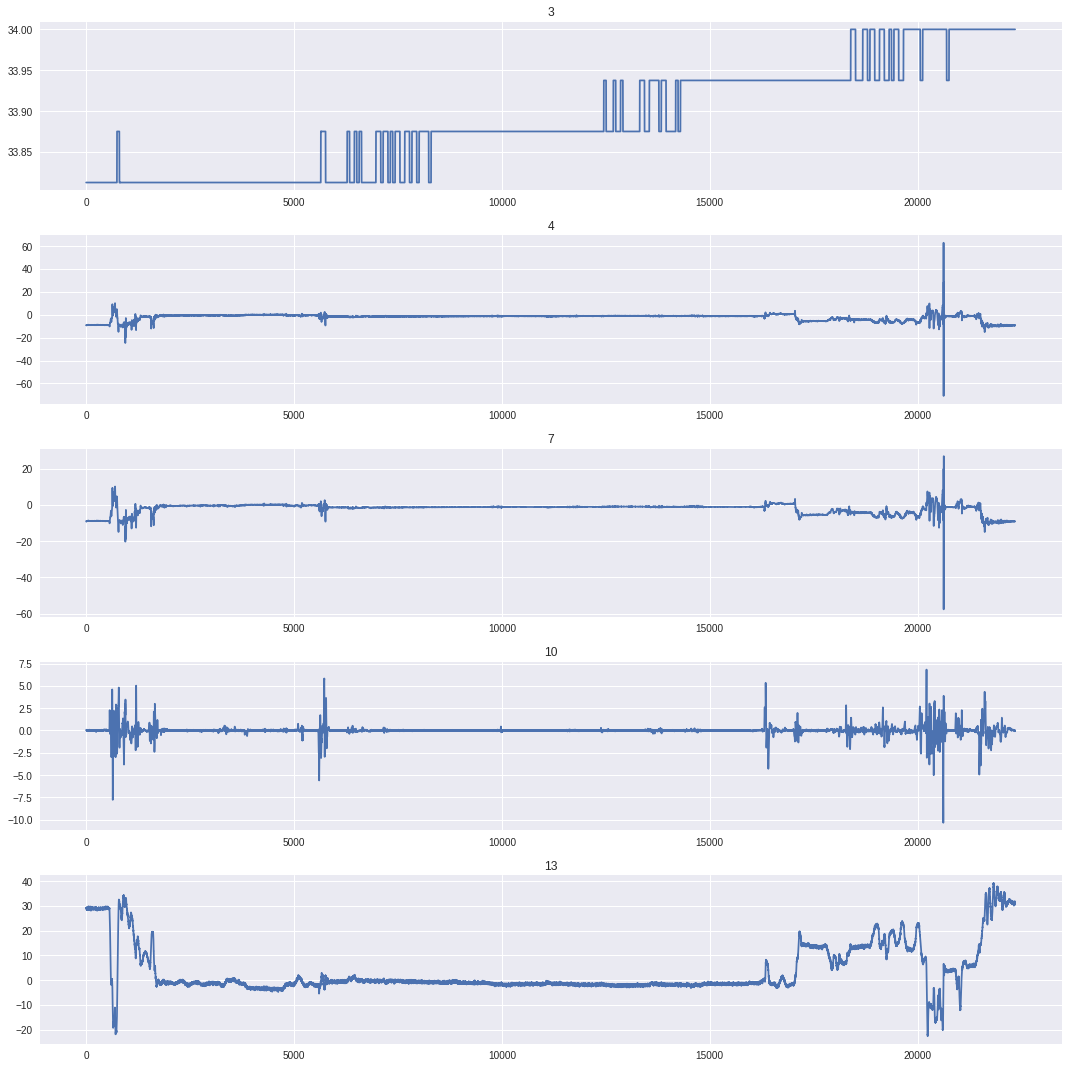

In [0]:
import matplotlib.pyplot as plt

def plotter(df):
  # Visualize response variable (total count) with other vars in hourly dataset
  col_list = [3, 4, 7, 10, 13]
  fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(15,15))
  for i in range(len(col_list)):
    ax[i].plot(df[col_list[i]], label=col_list[i])
    ax[i].set_title(col_list[i])
  plt.tight_layout()
  plt.show()
  
plotter(sit2)

<h2>(12020: jogging, general)
(12030: running, 5mph)</h2>

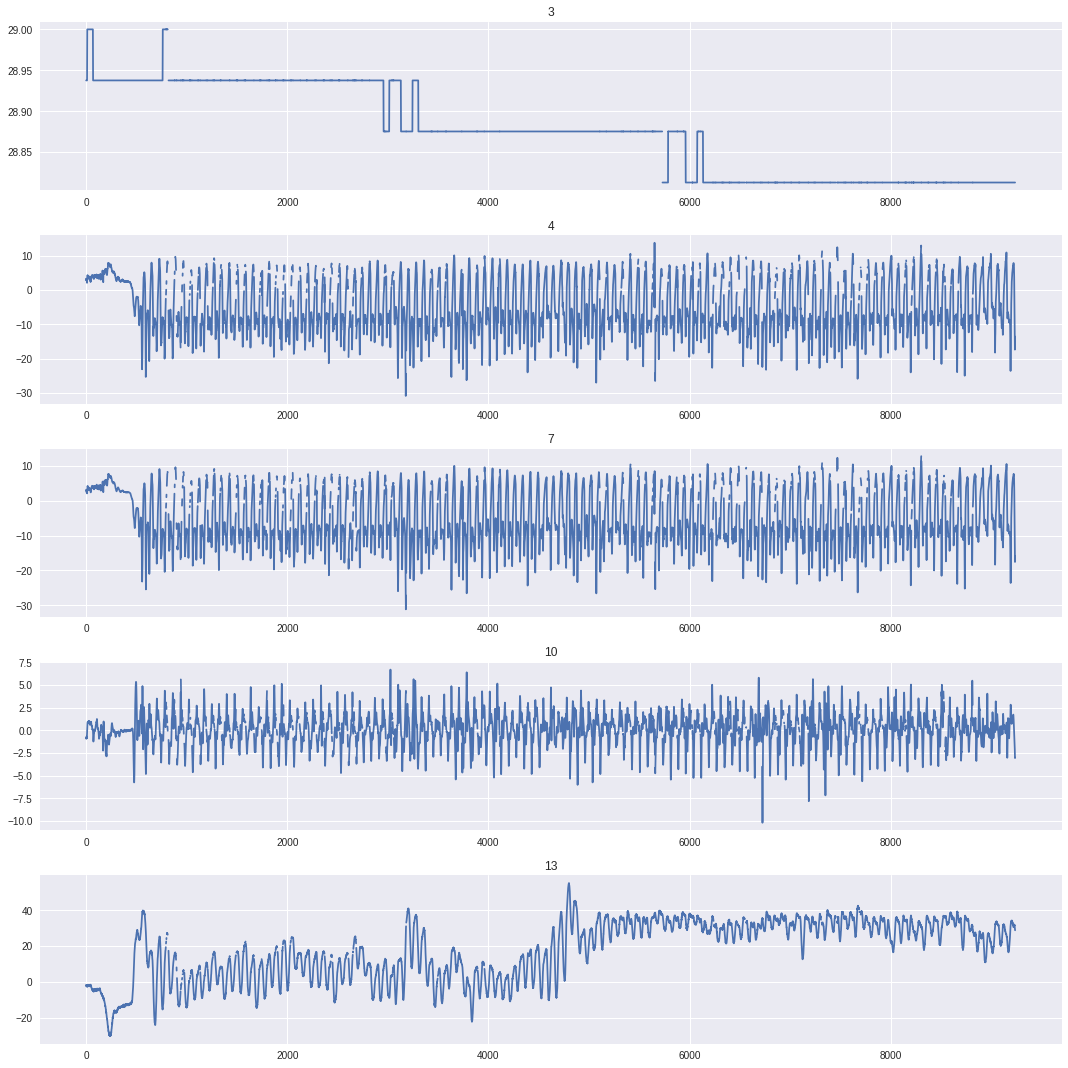

In [0]:
plotter(run2)

<h2>walking upstairs</h2>

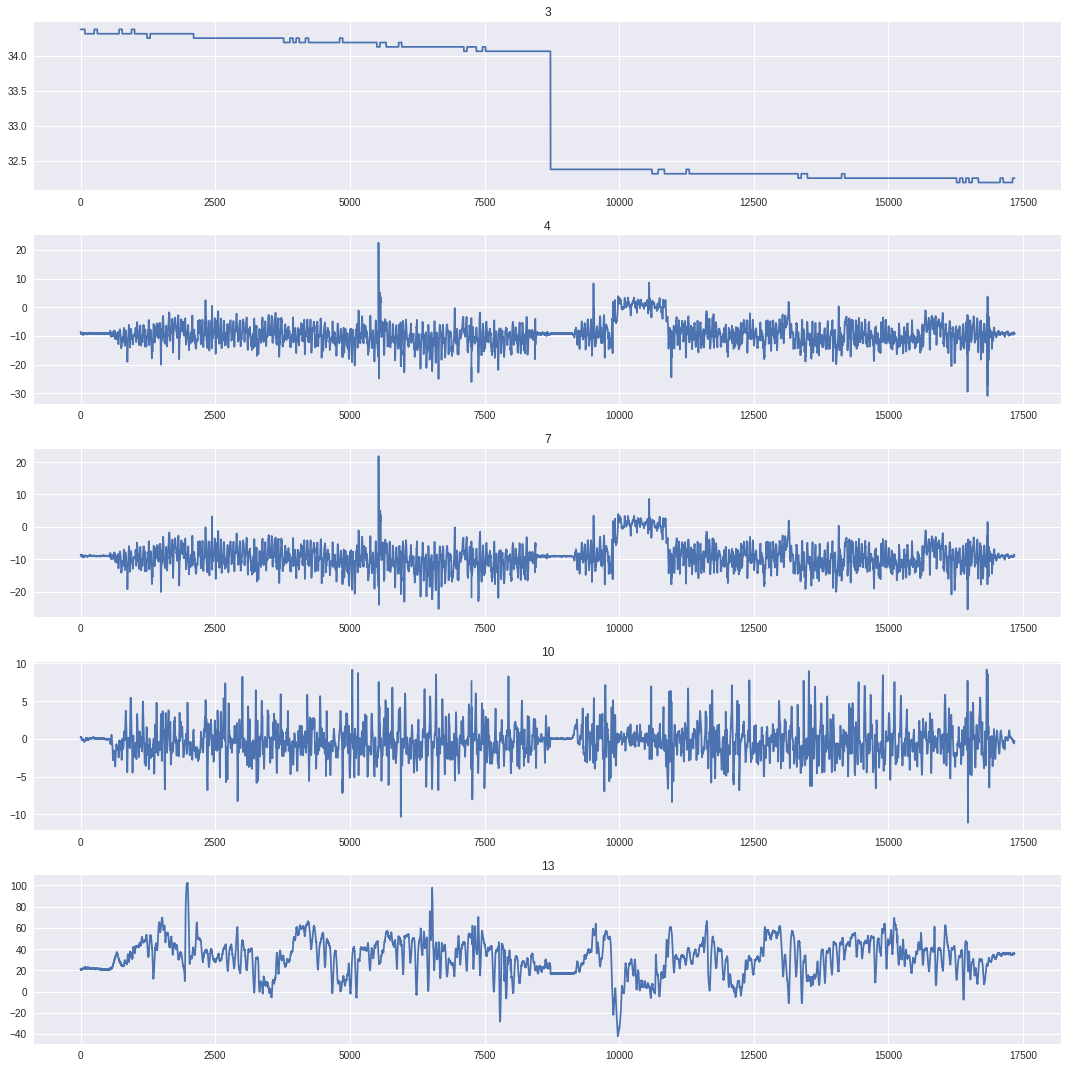

In [0]:
plotter(stairs2)

<h2>Vacuuming!</h2>

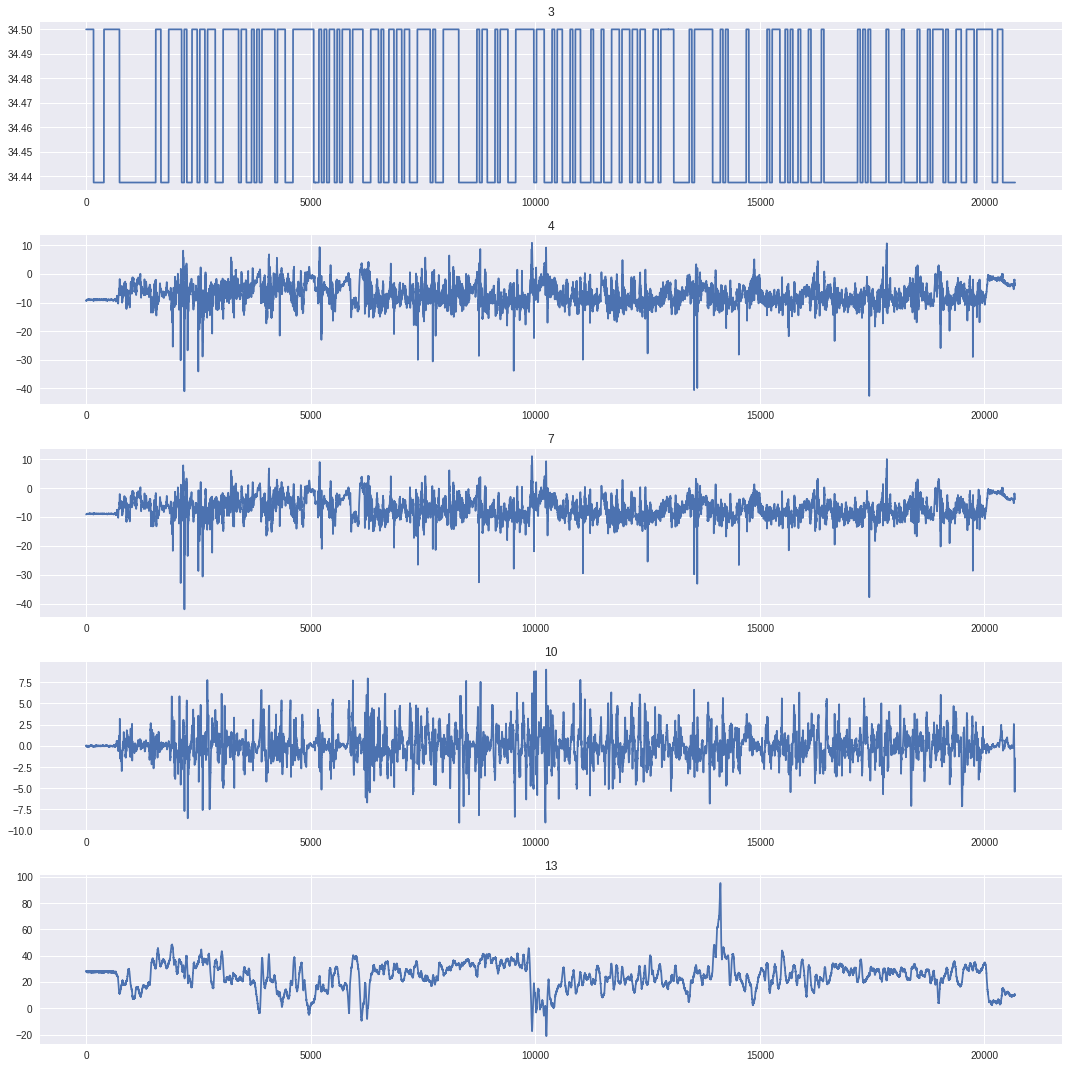

In [0]:
plotter(vac2)

#Prepare and Transform Data

**Only get the columns of measurements**

In [0]:
cols = [3, 4, 7, 10, 13]

sit_ = sit2[cols]
run_ = run2[cols]
stairs_ = stairs2[cols]
vac_ = vac2[cols]

In [0]:
sit_.head()

,3,4,7,10,13
0,33.8125,-9.20318,-9.05445,0.027396,29.0299
1,33.8125,-9.20077,-9.09992,0.005702,29.1336
2,33.8125,-9.27823,-9.10043,0.012111,29.0230
3,33.8125,-9.27956,-9.07029,0.007302,29.0253
4,33.8125,-9.21200,-9.08573,0.012445,28.8073


**Transpose the dataframe so that columns are timesteps**

In [0]:
#0 is the oldest date
#last col is the newest date

sit_t = sit_.transpose()
run_t = run_.transpose()
stairs_t = stairs_.transpose()
vac_t = vac_.transpose()


In [0]:
sit_t.head()

,0,1,2,3,4,5,6,7,8,9,...,22335,22336,22337,22338,22339,22340,22341,22342,22343,22344
3,33.812500,33.812500,33.812500,33.812500,33.812500,33.812500,33.812500,33.812500,33.812500,33.81250,...,34.000000,34.000000,34.000000,34.000000,34.00000,34.000000,34.000000,34.000000,34.000000,34.000000
4,-9.203180,-9.200770,-9.278230,-9.279560,-9.212000,-9.093820,-9.204780,-9.059240,-9.166460,-9.17047,...,-9.221290,-9.379140,-9.217280,-9.181360,-9.11007,-9.484750,-9.254270,-9.218350,-9.253470,-9.220760
7,-9.054450,-9.099920,-9.100430,-9.070290,-9.085730,-9.039760,-9.025200,-8.965670,-8.965920,-8.98099,...,-9.109810,-9.064590,-9.139820,-9.124380,-9.10968,-9.110060,-9.109680,-9.064220,-9.063330,-9.078660
10,0.027396,0.005702,0.012111,0.007302,0.012445,0.003822,0.009719,0.032421,0.048591,0.04696,...,-0.045493,-0.090596,-0.045641,0.009016,0.01113,0.003338,-0.015941,-0.006883,-0.044724,-0.008801
13,29.029900,29.133600,29.023000,29.025300,28.807300,28.799200,29.251000,29.246300,28.804000,29.24820,...,31.186500,31.075900,31.314400,31.201300,30.40140,30.848100,30.857700,31.426100,30.871400,31.654300


#Sit Model 

This tutorial uses references from three key online sources: 



1.  <i>A ten-minute introduction to sequence-to-sequence learning in Keras</i>, https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
2.   <i>DEPLOYING A SEQ2SEQ MODEL WITH THE HYBRID FRONTEND</i>, https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html
3.  <i>TimeSeries_Seq2Seq by JEddy92</i> at https://github.com/JEddy92/TimeSeries_Seq2Seq



<h1>Use the "Walk Forward Split" Method to Partition the Dataset</h1>

Reference: https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md

<img src="https://github.com/Arturus/kaggle-web-traffic/raw/master/images/split.png" width=600 height=300></img>

In [0]:
sit_t.shape[1]

22345

In [0]:
#Reference: From https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

from datetime import timedelta

pred_steps = 3000 #seconds we want to forecast out - 30 sec * 100 sample freqency = 300

pred_length= 3000

first_day = 0
last_day = sit_t.shape[1] #22345

val_pred_start = last_day - pred_length -1 #22345 - 3000 -1  = 19344
val_pred_end = last_day #22345

train_pred_start = val_pred_start - pred_length - 1 #19344 - 3000 -1 = 16343
train_pred_end = val_pred_start - 1 #19344 - 1 = 19343

enc_length = train_pred_start - first_day #16343 - 0 = 16343

train_enc_start = first_day #0
train_enc_end = train_enc_start + enc_length - 1 #0 + 16343 - 1= 16342

val_enc_start = train_enc_start + pred_length #0 + 3000
val_enc_end = val_enc_start + enc_length  #3000 + 16342 = 19342


In [0]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length)
print('Prediction interval:', pred_length)

Train encoding: 0 - 16342
Train prediction: 16343 - 19343 

Val encoding: 3000 - 19343
Val prediction: 19344 - 22345

Encoding interval: 16343
Prediction interval: 3000


<table>
  <th>Timestamp</th>
  <th>Name</th>
  <tr>
    <td>0</td>
    <td>`train_enc_start`</td>
  </tr>
  <tr>
    <td>16342</td>
    <td>`train_enc_end`</td>
  </tr>
  <tr>
    <td>16343</td>
    <td>`train_pred_start`</td>
  </tr>
  <tr>
    <td>19343</td>
    <td>`train_pred_end`</td>
  <tr>
    <td>3000</td>
    <td>`val_enc_start`</td>
  </tr>
   <tr>
    <td>19343</td>
    <td>`val_enc_end`</td>
  </tr>
  <tr>
    <td>19344</td>
    <td>`val_pred_start`</td>
  </tr>
  <tr>
    <td>22345</td>
    <td>`val_pred_end`</td>
  </tr>
    
  </table>

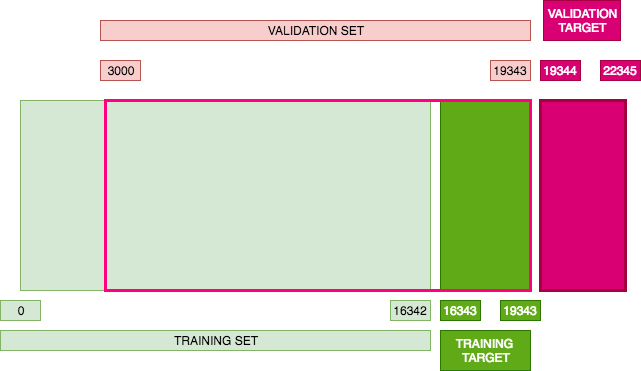

In [0]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Jean Bartik Tutorial/walkforward.png")

Our dataset will include all the IMU sensors of interest: 


*   Temperature
*   Accelerometer 1
*  Accelerometer 2
*  Gyroscope
*  Magnetometer



In [0]:
#Our dataset raw not transformed

series_array = sit_t[sit_t.columns[1:]].values
series_array

array([[ 3.38125e+01,  3.38125e+01,  3.38125e+01, ...,  3.40000e+01,
         3.40000e+01,  3.40000e+01],
       [-9.20077e+00, -9.27823e+00, -9.27956e+00, ..., -9.21835e+00,
        -9.25347e+00, -9.22076e+00],
       [-9.09992e+00, -9.10043e+00, -9.07029e+00, ..., -9.06422e+00,
        -9.06333e+00, -9.07866e+00],
       [ 5.70234e-03,  1.21106e-02,  7.30193e-03, ..., -6.88330e-03,
        -4.47241e-02, -8.80064e-03],
       [ 2.91336e+01,  2.90230e+01,  2.90253e+01, ...,  3.14261e+01,
         3.08714e+01,  3.16543e+01]])

In [0]:
series_array.shape

(5, 22344)

<h2>Use `JEddy92's` code to transform the input (X) (he calls it `encode`) and the output (y) (he calls it `decode`)</h2>

Note in the Kaggle competition he competed in to apply this code, he uses a `log1p` transform which means via NumPy documentation that: 
> For real-valued input, `log1p` is accurate also for `x` so small that `1 + x == 1` in floating-point accuracy.

In many of these Kaggle competitions, people are using `log1p` to transform even very small floating point values to 1.0 as opposed to a standard `log` transformation that transform is to zero, which isn't correct since it's not zero, just a very tiny floatig point value. This StackOverflow post https://stackoverflow.com/questions/49538185/what-is-the-purpose-of-numpy-log1p helps give an example: 

    np.log(1e-100 + 1)
    >> 0.0
    
    np.log1p(1e-100)
    >>1e-100

We do have several small floating point values in our data, so using this `log1p` transform is helpful. 

In [0]:
#toy example

sample = np.log1p([1, np.e, np.e**2, -3.2, -0.1, 2, 4, -4.555, 85])
sample

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


array([ 0.69314718,  1.31326169,  2.12692801,         nan, -0.10536052,
        1.09861229,  1.60943791,         nan,  4.4543473 ])

In [0]:

#Modified from https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

def get_time_block_series(series_array, start, end):
    
    return series_array[:,start:end]

def transform_series_encode(series_array):
    
    series_array = np.log1p(series_array) 
    series_array = np.nan_to_num(series_array)# filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(series_array) 
    series_array = np.nan_to_num(series_array)# filling NaN with 0
    series_array = series_array - encode_series_mean #using the mean of the history_x set to difference the target set
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

#Part 2 - CNNS using WaveNet


It would be a total lie if I didn't say that I learned a great deal about a basic WaveNet implementation without this excellent tutorial written by an instructor from Metis.  Many of his descriptions provided me a good understanding of how WaveNet's architecture functions. 


>> "This convolutional architecture is a simplified version of the WaveNet model, designed as a generative model for audio (in particular, for text-to-speech applications). The wavenet model can be abstracted beyond audio to apply to any time series forecasting problem, providing a nice structure for capturing long-term dependencies without an excessive number of learned weights."

Reference: https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb



Per Chris Olah - <b>Consider a 1-dimensional convolutional layer with inputs {x_n} and outputs {y_n}</b>, Reference: http://colah.github.io/posts/2014-07-Understanding-Convolutions/

<img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/Conv-9-Conv2-XY.png">

With a 1D convolutional layer, you'll notice that the hidden layer is being fed weights generated from the connections of both the current timestep (x_0) as well as the future time step (x_1) which would be considered cheating. As a result, there is the method of a `casual` layer. In Keras when specifying the 1D convolutional, you can set `padding = causal` to implement this design.

<img src="https://github.com/JEddy92/TimeSeries_Seq2Seq/raw/5f6c5db965c8080b1078b9f50ea2dd92962388db/notebooks/images/WaveNet_causalconv.png">

Image from the 2016 publication on WavNet, found here: https://arxiv.org/pdf/1609.03499.pdf (and also in your folder)


However, you might notice that in order to generate one timestep prediction (output), it took 5 timesteps (input). For each additional timestep that we would want to include in our history - or that we'd reach back into the past for - we'd have to add another hidden layer. This becomes a challenge when we want longer and longer sequences for the network to remember and to use to generate predictions. As a result, there is another design called <b>dilation</b>.  

You might recall in image convolutions that there is a filter, or rather a "receptive field" used to convolve against an input image. For example, a 3 x 3 filter or receptive field. The same idea applies to a 1D convolution on a waveform signal. We want to increase the size of this filter or this receptive field, so that it can flexibly convolve against more lengths of the sequences in the past. by increasing our receptive field at each hidden layer, we can reach far back in time without having to increase the size of the network. 

>>"By increasing the dilation rate multiplicatively at each layer (e.g. 1, 2, 4, 8, ...), we can achieve the exponential relationship between layer count and receptive field size that we desire. In the diagram, you can see how we now only need 4 layers to connect all of the 16 input series values to the highlighted output (say the 17th time step value)."

<img src="https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif">

<h1>Extract the Training Data from the Series Array</h1>

In [0]:
##this

print(train_enc_start, train_enc_end)
print(train_pred_start, train_pred_end)
print(val_enc_start, val_enc_end)
print(val_pred_start, val_pred_end)


first_n_samples = 15000

#the entire dataset
series_array = series_array


#TRAINING HISTORY
# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, train_enc_start, train_enc_end)[:first_n_samples]

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


#TRAINING TARGET, 3000 STEPS
# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, train_pred_start, train_pred_end)[:first_n_samples]

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)



0 16342
16343 19343
3000 19343
19344 22345


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log1p


In [0]:
#this

print(encoder_input_data.shape) #training history - the training set is the first 16,342 timesteps 
print(decoder_target_data.shape) #training target: y 

(5, 16342, 1)
(5, 3000, 1)


In [0]:
# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [0]:
print(lagged_target_history.shape) 
print(encoder_input_data.shape) #this is what the model will be trained on: X history sequence - it is 3000 additional timesteps

(5, 2999, 1)
(5, 19341, 1)


In [0]:
series_array[0] #for temperature

array([33.8125, 33.8125, 33.8125, ..., 34.    , 34.    , 34.    ])

In [0]:
print(encoder_input_data) 
print(encoder_input_data.shape)

[[[-8.81480877e-04]
  [-8.81480877e-04]
  [-8.81480877e-04]
  ...
  [ 4.49006292e-03]
  [ 4.49006292e-03]
  [ 4.49006292e-03]]

 [[ 2.94636304e-01]
  [ 2.94636304e-01]
  [ 2.94636304e-01]
  ...
  [ 2.94636304e-01]
  [ 2.94636304e-01]
  [ 2.94636304e-01]]

 [[ 4.58318939e-01]
  [ 4.58318939e-01]
  [ 4.58318939e-01]
  ...
  [ 4.58318939e-01]
  [ 4.58318939e-01]
  [ 4.58318939e-01]]

 [[ 6.41187665e-03]
  [ 1.27635869e-02]
  [ 8.00113343e-03]
  ...
  [-1.50412322e-01]
  [-6.81852128e-02]
  [-9.55633854e-02]]

 [[ 3.35745985e+00]
  [ 3.35378277e+00]
  [ 3.35385938e+00]
  ...
  [ 2.93164038e+00]
  [ 2.94291556e+00]
  [ 2.94270959e+00]]]
(5, 19341, 1)


**Model**

In [0]:
#TCN

#REference: https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

seq_length = pred_steps #prediction length

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':seq_length})(x)

model = Model(history_seq, pred_seq_train)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          2080      
__________

Fit on encoder_input_data which is (5, 19341, 1) = X and decoder_target_data which is (5, 3000, 1) = y. 

Remember that 5 means: temp, accel1, accel2, gyro, and mag. 

<h3>Let's visualize the transformations, compared to the original</h3>

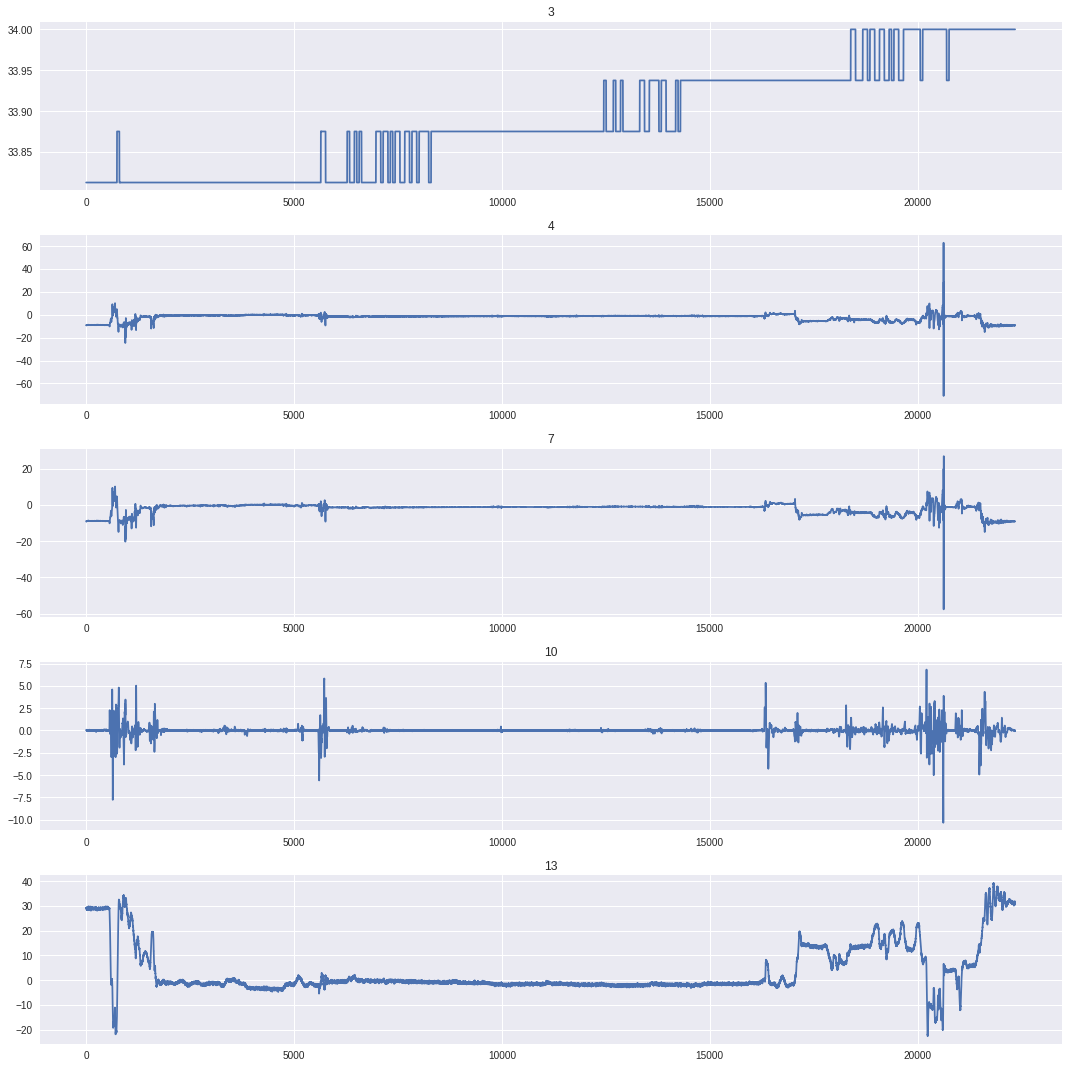

In [0]:
#The original 

plotter(sit2)

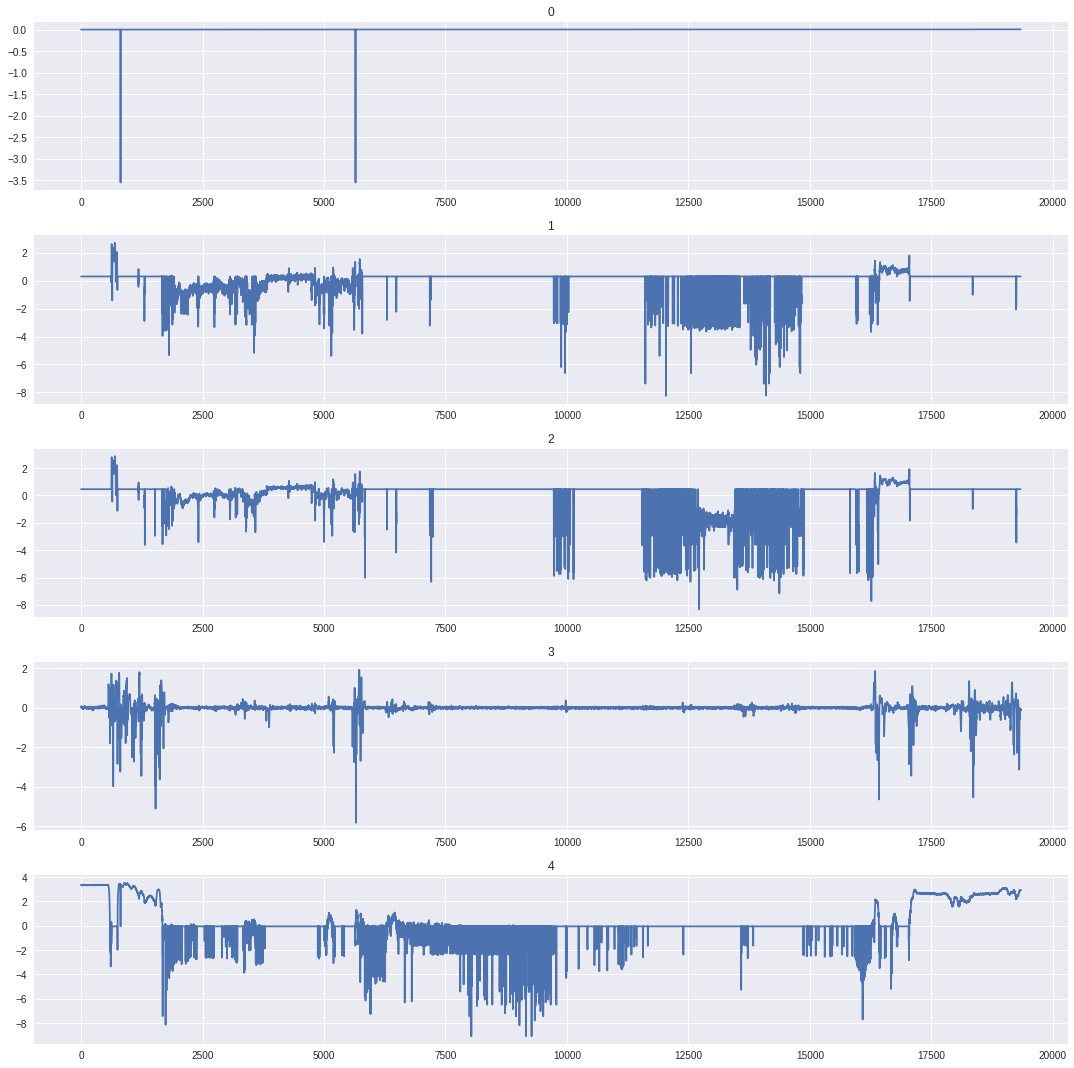

In [0]:
def plotter_trf(df):
  # Visualize response variable (total count) with other vars in hourly dataset
  col_list = [0, 1, 2, 3, 4]
  fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(15,15))
  for i in range(len(col_list)):
    ax[i].plot(df[col_list[i]], label=col_list[i])
    ax[i].set_title(col_list[i])
  plt.tight_layout()
  plt.show()

  
trf_training_encoder_data = pd.DataFrame(encoder_input_data.reshape(encoder_input_data.shape[0],encoder_input_data.shape[1]))
trp = trf_training_encoder_data.transpose()

plotter_trf(trp)

#Fit Model on Training Data

In [0]:
#fit model

batch_size = 2**11 #this means 2^11 (exponential) = 2048 - approximately 11 sets in our sit dataset
epochs = 50


model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Train on 4 samples, validate on 1 samples
Epoch 1/50
4/4 [==============================] - 1s 299ms/step - loss: 0.3019 - val_loss: 1.8239
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.2704 - val_loss: 1.5297
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 0.2316 - val_loss: 1.1191
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1816 - val_loss: 0.5785
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1358 - val_loss: 0.4546
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1687 - val_loss: 0.4476
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1529 - val_loss: 0.3111
Epoch 8/50
4/4 [==============================] - 0s 15ms/step - loss: 0.1215 - val_loss: 0.5269
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1364 - val_loss: 0.5665
Epoch 10/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1447 - val

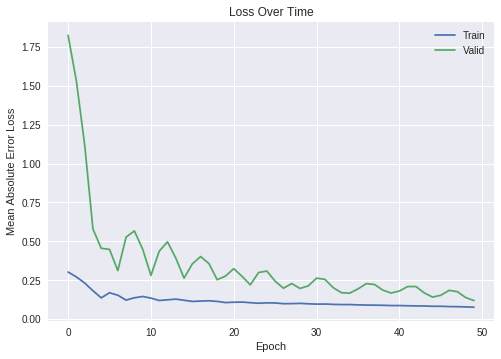

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

<h1>Extract the Validation Set from the Series Array</h1>

In [0]:
#now creating the validation sets


#encoder (history) - Validation X
encoder_input_data = get_time_block_series(series_array, val_enc_start, val_enc_end) #val_x set extracted

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data) #val_x log1p transformed


#decoder (target) - Validation y
decoder_target_data = get_time_block_series(series_array, val_pred_start, val_pred_end) #val_y set extracted

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean) #val_y log1p transformed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log1p


In [0]:
print("Validation Encoder Input, val_x, is:", encoder_input_data.shape)
print("Validation Decoder Target, val_y, is:", decoder_target_data.shape)


Validation Encoder Input, val_x, is: (5, 16343, 1)
Validation Decoder Target, val_y, is: (5, 3000, 1)


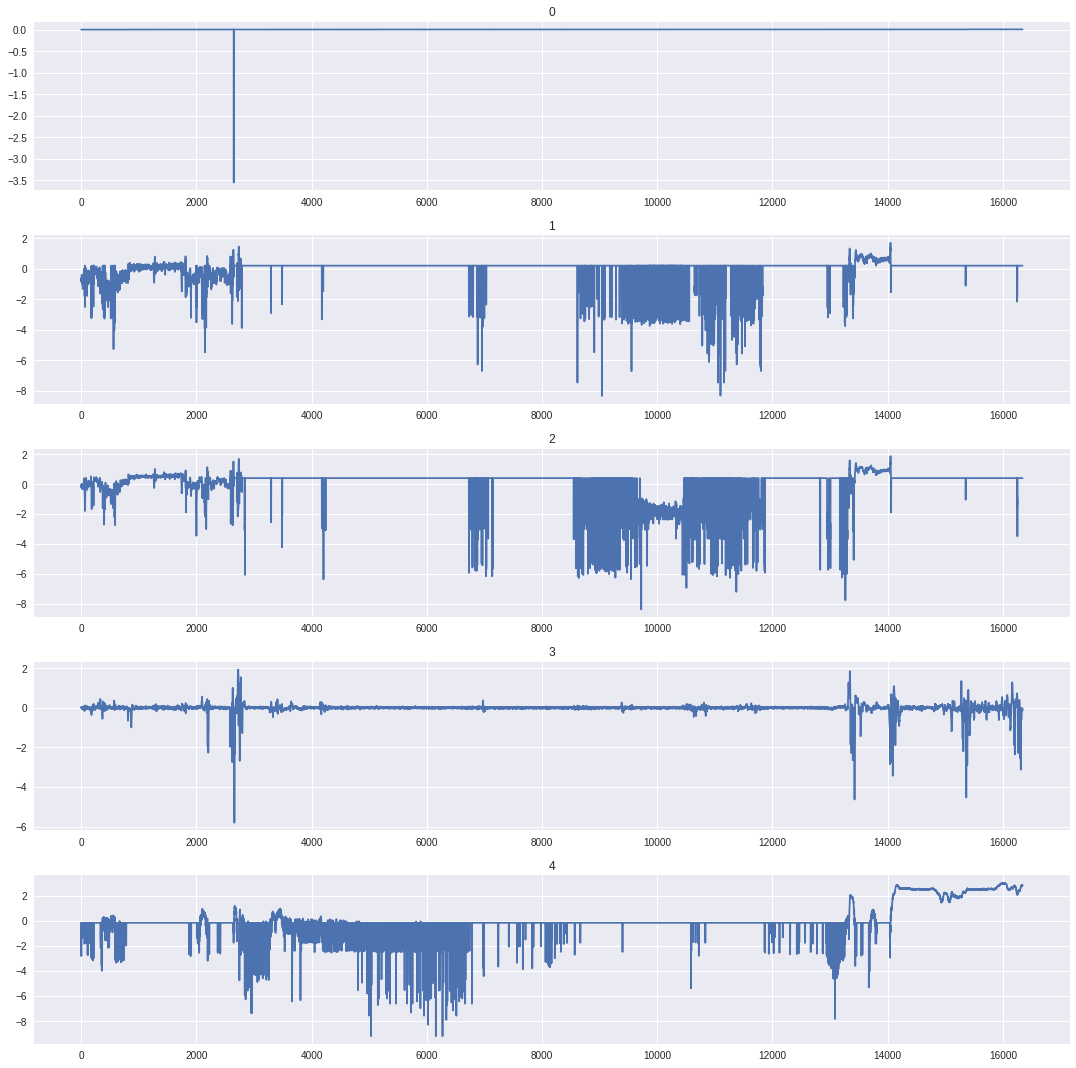

In [0]:
#check the transformation of encoder_input_data

trf_val_encoder_data = pd.DataFrame(encoder_input_data.reshape(encoder_input_data.shape[0],encoder_input_data.shape[1]))
trp_v = trf_val_encoder_data.transpose()

plotter_trf(trp_v)

#Predict on the Validation Set

In [0]:
def predictions(ix, val_x, val_actuals, tail):
  """
  ix: index of interest - your sensor
  val_x: encoder_input_data
  val_actuals: decoder_target_data
  tail: get the last x timesteps of the validation x set for the index of interest
  
  """
  #validation x set - make the predictions
  validation_set_predictions = model.predict(val_x)
  print("Shape of all validation set predictions:", validation_set_predictions.shape)
  
  #fetch the index of interest from the predictions
  pred_val_idx = validation_set_predictions[ix, :, :]
  print("Predictions shape for index of interest:", pred_val_idx.shape)
  
  #fetch the index of interest from the actuals
  truth_val_idx = val_actuals[ix, :]
  truth_val_idx = np.reshape(truth_val_idx, (len(truth_val_idx),-1))
  print("Actuals shape for index of interest:", truth_val_idx.shape)
  
  #get the last x timesteps from the validation_x set 
  last_x_steps = (val_x[ix, :, :])[-tail:]
  
  #set a new var
  preds = pred_val_idx
  
  #set a new var
  truth = truth_val_idx
  
  #timeseries plot
  plt.figure(figsize=(20,6))   
    

  #if your tail is 1000 then (1, tail+1) = (1, 1001)
  #(1000, 4000) actual
  #(1000, 4000) predictions overlaid

  plt.plot(range(1,tail+1),last_x_steps)
  plt.plot(range(tail,tail+3000),truth,color='orange') 
  plt.plot(range(tail,tail+3000),preds,color='teal',linestyle='--')

  plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % tail)
  plt.legend(['Encoding Series','Target Series','Predictions'])

  

##run this function if you just want the prediction arrays
def fetch_preditions_only(ix, val_x, val_actuals):

  """
  ix: index of interest - your sensor
  val_x: encoder_input_data
  val_actuals: decoder_target_data
  
  """
  #validation x set - make the predictions
  validation_set_predictions = model.predict(val_x)
  print("Shape of all validation set predictions:", validation_set_predictions.shape)
  
  #fetch the index of interest from the predictions
  pred_val_idx = validation_set_predictions[ix, :, :]
  print("Predictions shape for index of interest:", pred_val_idx.shape)
  
  #fetch the index of interest from the actuals
  truth_val_idx = val_actuals[ix, :]
  truth_val_idx = np.reshape(truth_val_idx, (len(truth_val_idx),-1))
  print("Actuals shape for index of interest:", truth_val_idx.shape)

  return pred_val_idx, truth_val_idx

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


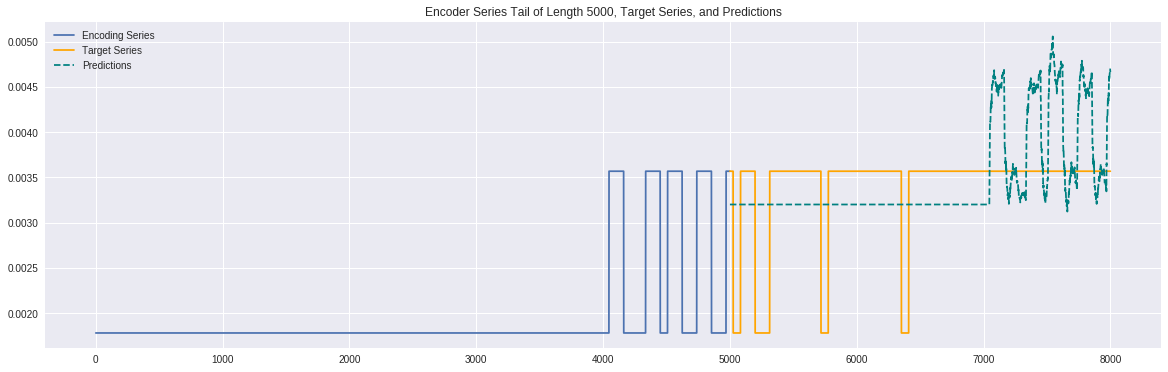

In [0]:
#predictions(ix, val_x, val_actuals, tail)

predictions(0, encoder_input_data, decoder_target_data, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


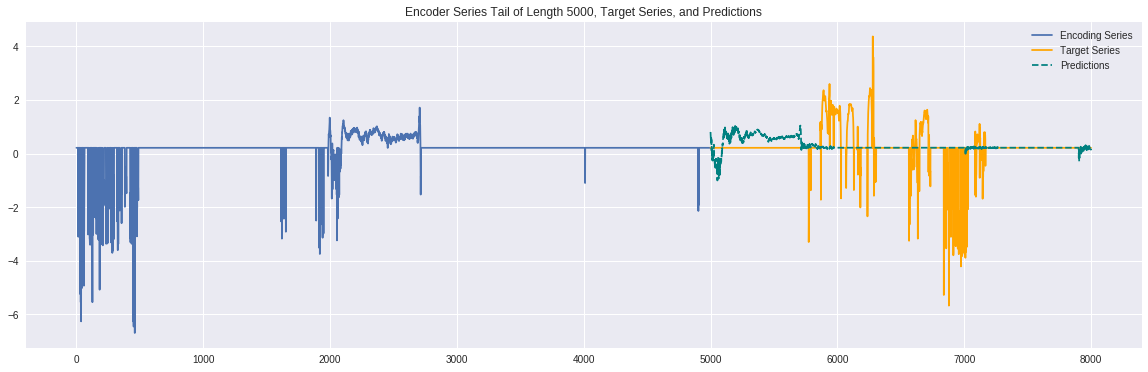

In [0]:
predictions(1, encoder_input_data, decoder_target_data, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


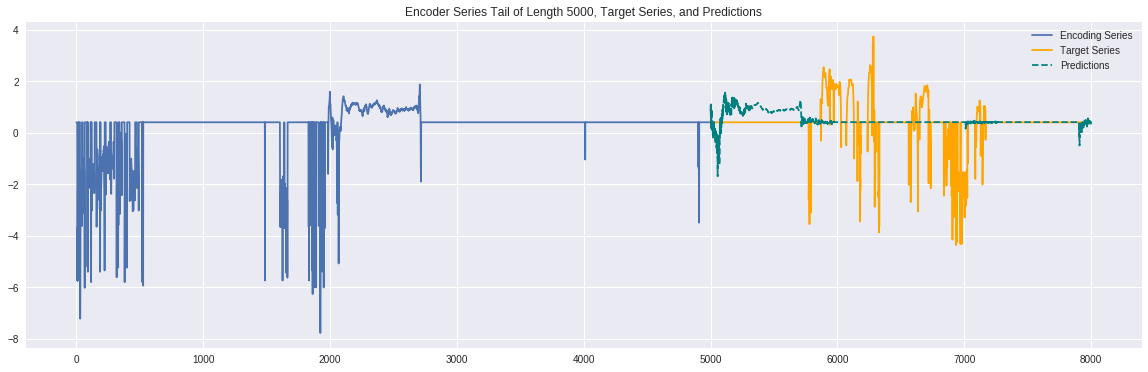

In [0]:
predictions(2, encoder_input_data, decoder_target_data, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


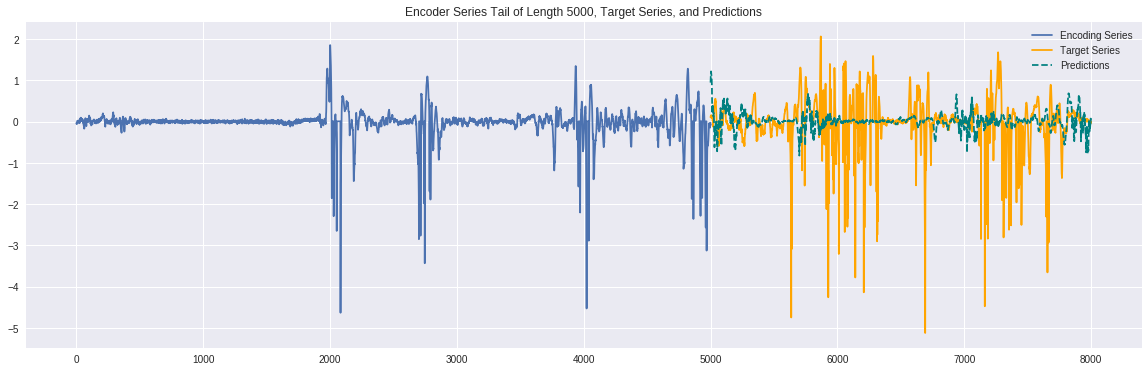

In [0]:
predictions(3, encoder_input_data, decoder_target_data, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


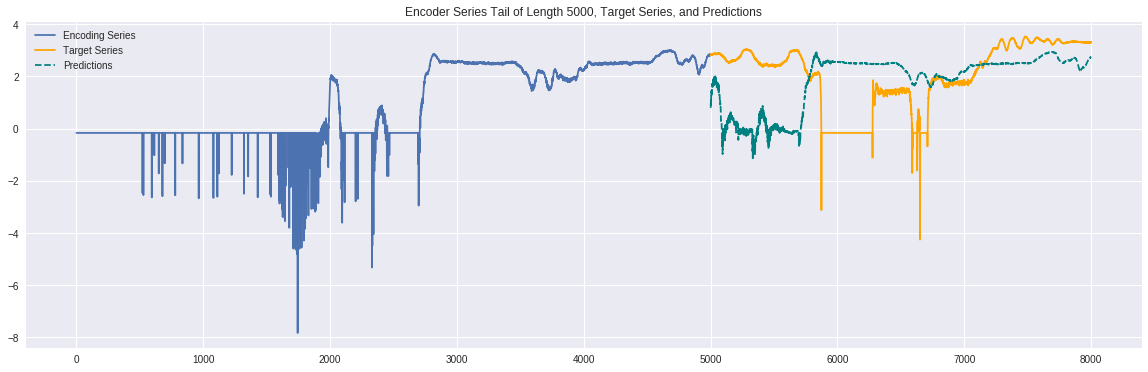

In [0]:
predictions(4, encoder_input_data, decoder_target_data, 5000)

//END - ALL BELOW ARE EXPERIMENTS

#Predict on Stairs

In [0]:

#ANY MODEL

def walk_forward(df):
	pred_steps = 3000 #seconds we want to forecast out - 30 sec * 100 sample freqency = 300
	pred_length= 3000
	first_day = 0
	last_day = df.shape[1] #22345

	#validation set for the target (decoder)
	val_pred_start = last_day - pred_length -1 #22345 - 3000 -1  = 19344
	val_pred_end = last_day #22345

	#training set for the target (decoder)
	train_pred_start = val_pred_start - pred_length - 1 #19344 - 3000 -1 = 16343
	train_pred_end = val_pred_start - 1 #19344 - 1 = 19343

	#encoding length
	enc_length = train_pred_start - first_day #16343 - 0 = 16343

	#training set for the history (encoder, x)
	train_enc_start = first_day #0
	train_enc_end = train_enc_start + enc_length - 1 #0 + 16343 - 1= 16342

	#validation set for the history (encoder, x)
	val_enc_start = train_enc_start + pred_length #0 + 3000
	val_enc_end = val_enc_start + enc_length  #3000 + 16342 = 19342

	return train_enc_start, train_enc_end, train_pred_start, train_pred_end, val_enc_start, val_enc_end, val_pred_start, val_pred_end, enc_length, pred_length, pred_steps




train_enc_start, train_enc_end, train_pred_start, train_pred_end, val_enc_start, val_enc_end, val_pred_start, val_pred_end, enc_length, pred_length, pred_steps = walk_forward(stairs_t)



In [0]:
def get_original_series(df):
	series_array = df[df.columns[1:]].values
	return series_array

series_array_stairs = get_original_series(stairs_t)

print(train_enc_start, train_enc_end)
print(train_pred_start, train_pred_end)
print(train_pred_end - train_pred_start) #should be 3000


0 11339
11340 14340
3000


In [0]:
def extract_training_data(series_array, train_enc_start, train_enc_end, train_pred_start, train_pred_end):
	first_n_samples = 15000

	#the entire dataset
	series_array = series_array

	#TRAINING HISTORY
	# sample of series from train_enc_start to train_enc_end  
	encoder_input_data = get_time_block_series(series_array, train_enc_start, train_enc_end)[:first_n_samples]
	encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


	#TRAINING TARGET, 3000 STEPS
	# sample of series from train_pred_start to train_pred_end 
	decoder_target_data = get_time_block_series(series_array, train_pred_start, train_pred_end)[:first_n_samples]
	decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

	# we append a lagged history of the target series to the input data, 
	# so that we can train with teacher forcing
	lagged_target_history = decoder_target_data[:,:-1,:1]
	encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

	print(encoder_input_data.shape) #training history
	print(decoder_target_data.shape) #training target: y 

	return encoder_input_data, decoder_target_data


encoder_input_data_st, decoder_target_data_st = extract_training_data(series_array_stairs, train_enc_start, train_enc_end, train_pred_start, train_pred_end)

(5, 14338, 1)
(5, 3000, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log1p


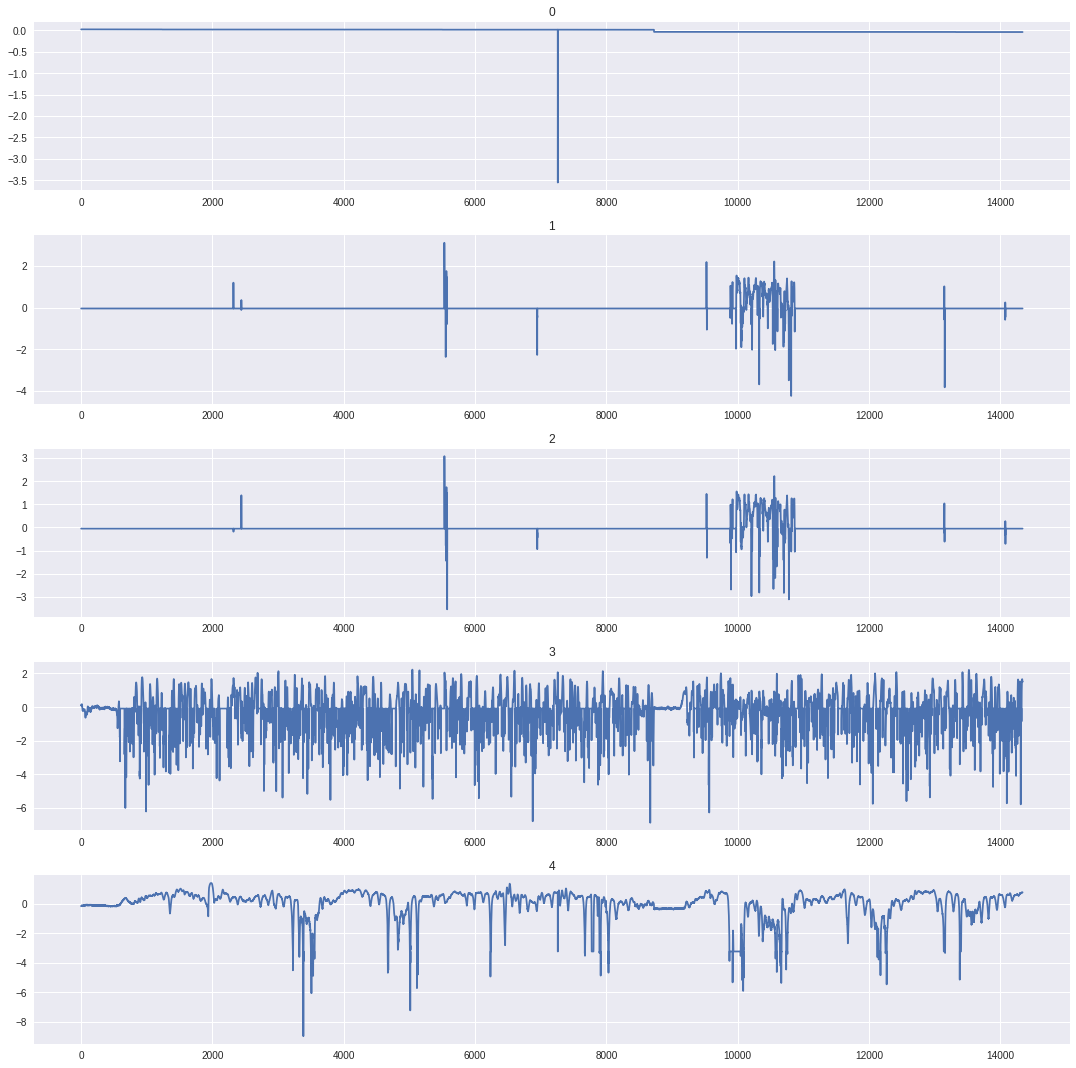

In [0]:
#print the transformations of the training set

def plot_transforms(encoder_input):
	trf_encoder_data = pd.DataFrame(encoder_input.reshape(encoder_input.shape[0],encoder_input.shape[1]))
	trp = trf_encoder_data.transpose()
	plotter_trf(trp)

plot_transforms(encoder_input_data_st)

Train on 4 samples, validate on 1 samples
Epoch 1/50
4/4 [==============================] - 1s 301ms/step - loss: 0.1252 - val_loss: 0.2201
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1429 - val_loss: 0.2519
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1143 - val_loss: 0.2957
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1278 - val_loss: 0.2999
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1262 - val_loss: 0.2736
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1146 - val_loss: 0.2289
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 0.1027 - val_loss: 0.1891
Epoch 8/50
4/4 [==============================] - 0s 12ms/step - loss: 0.1061 - val_loss: 0.1857
Epoch 9/50
4/4 [==============================] - 0s 12ms/step - loss: 0.1064 - val_loss: 0.2077
Epoch 10/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0986 - val

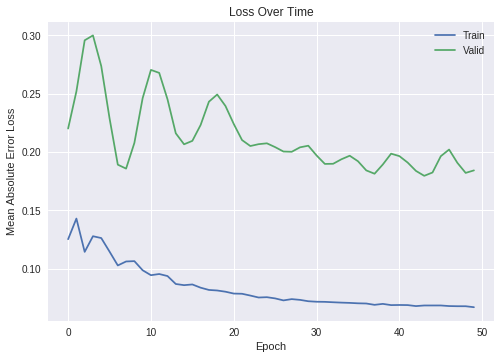

In [0]:
#fit the model - keep the original batch_size 
def fit_model(ep, encoder_input_data, decoder_target_data):
	batch_size = 2**11 #this means 2^11 (exponential) = 2048 - approximately 11 sets in our sit dataset
	
	model.compile(Adam(), loss='mean_absolute_error')

	history = model.fit(encoder_input_data, decoder_target_data, 
		batch_size=batch_size,
		epochs=ep,
		validation_split=0.2)
	print(history)

	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])

	plt.xlabel('Epoch')
	plt.ylabel('Mean Absolute Error Loss')
	plt.title('Loss Over Time')
	plt.legend(['Train','Valid'])

	return model 

model_st = fit_model(50, encoder_input_data_st, decoder_target_data_st)

In [0]:
#VALIDATION SET

def extract_validation_data(series_array, val_enc_start, val_enc_end, val_pred_start, val_pred_end):
	#the entire dataset
	series_array = series_array

	#VALIDATION HISTORY
	# sample of series from train_enc_start to train_enc_end  
	encoder_input_data = get_time_block_series(series_array, val_enc_start, val_enc_end)
	encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


	#VALIDATION TARGET, 3000 STEPS
	# sample of series from train_pred_start to train_pred_end 
	decoder_target_data = get_time_block_series(series_array, val_pred_start, val_pred_end)
	decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


	print(encoder_input_data.shape) #training history
	print(decoder_target_data.shape) #training target: y 

	return encoder_input_data, decoder_target_data

encoder_input_data_st_VAL, decoder_target_data_st_VAL = extract_validation_data(series_array_stairs, val_enc_start, val_enc_end, val_pred_start, val_pred_end)

(5, 11340, 1)
(5, 3000, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log1p


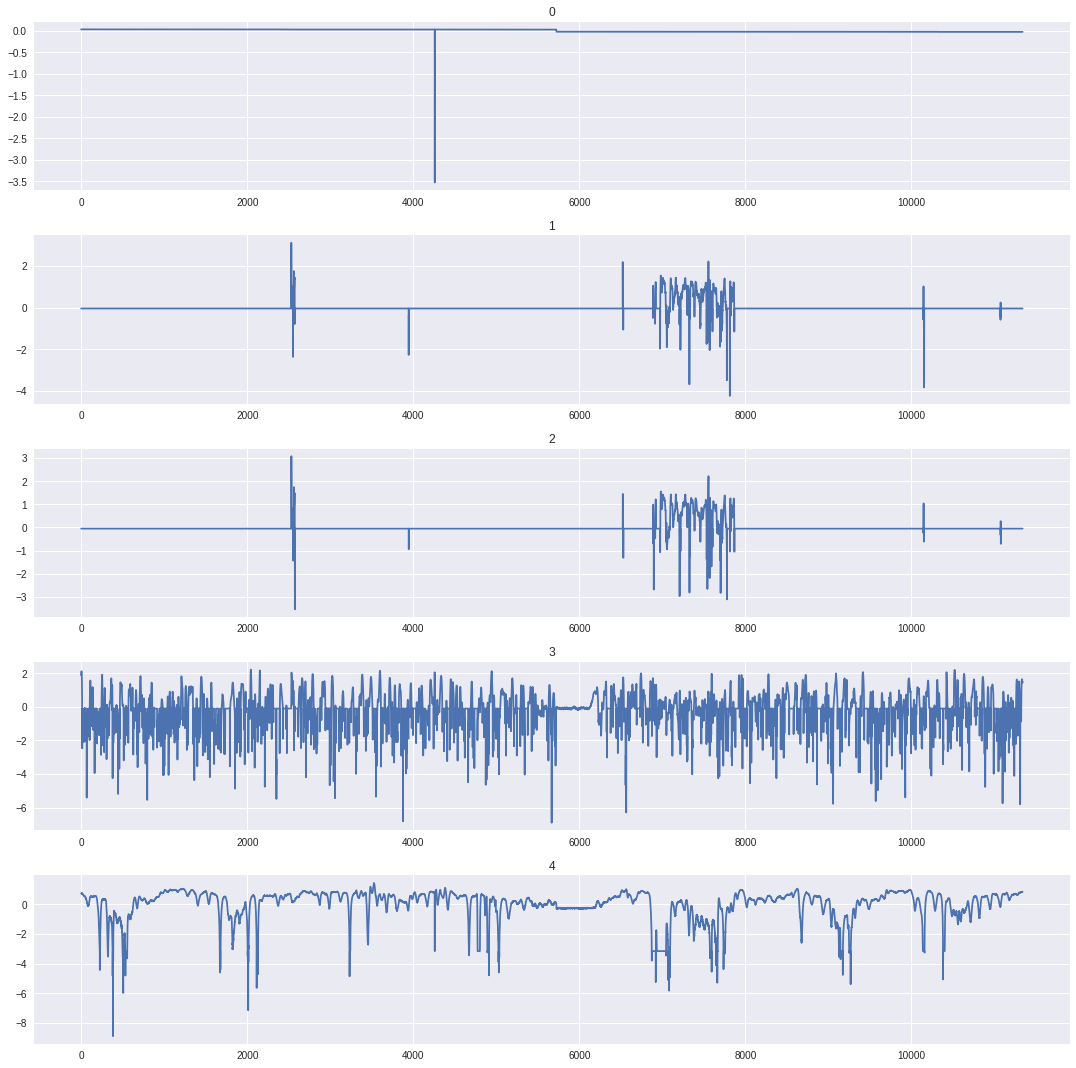

In [0]:
#PLOT

plotter_trf(encoder_input_data_st_VAL)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


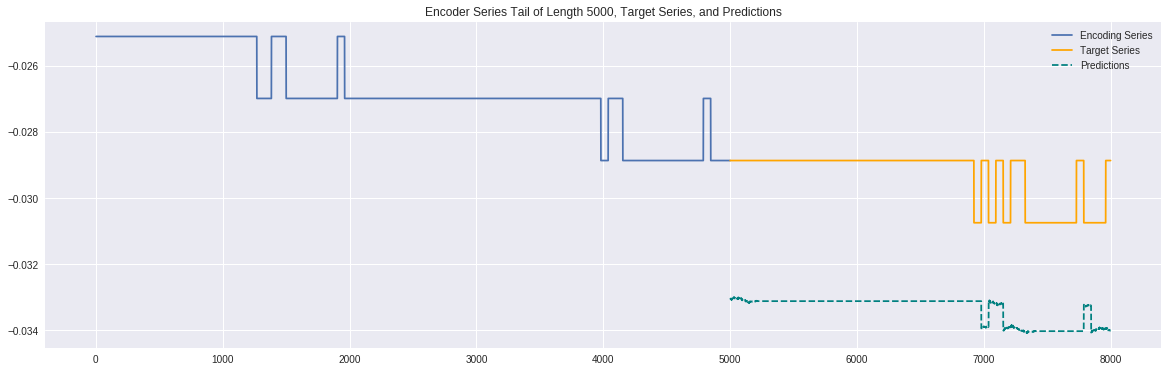

In [0]:
#MAKE PREDICTIONS

predictions(0, encoder_input_data_st_VAL, decoder_target_data_st_VAL, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


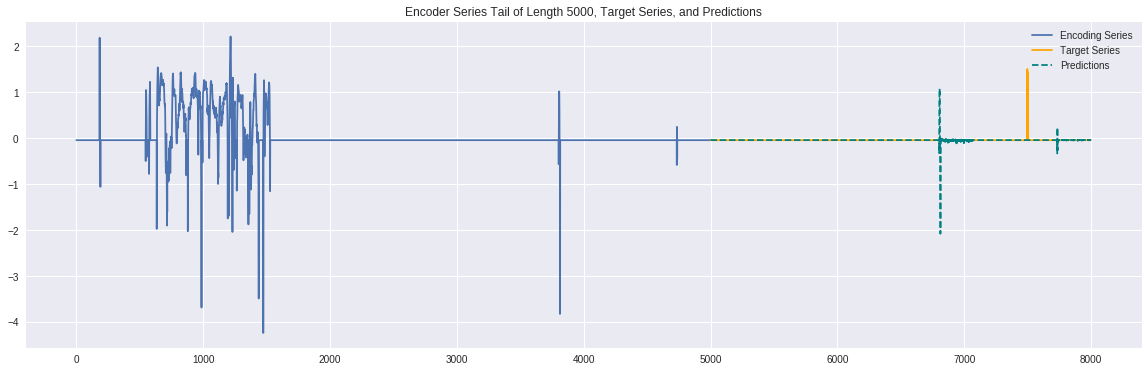

In [0]:
#MAKE PREDICTIONS

predictions(1, encoder_input_data_st_VAL, decoder_target_data_st_VAL, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


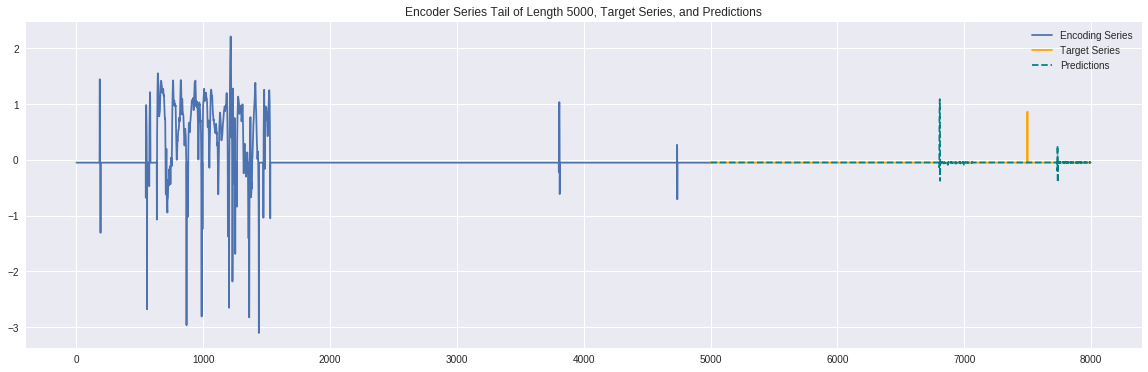

In [0]:
#MAKE PREDICTIONS

predictions(2, encoder_input_data_st_VAL, decoder_target_data_st_VAL, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


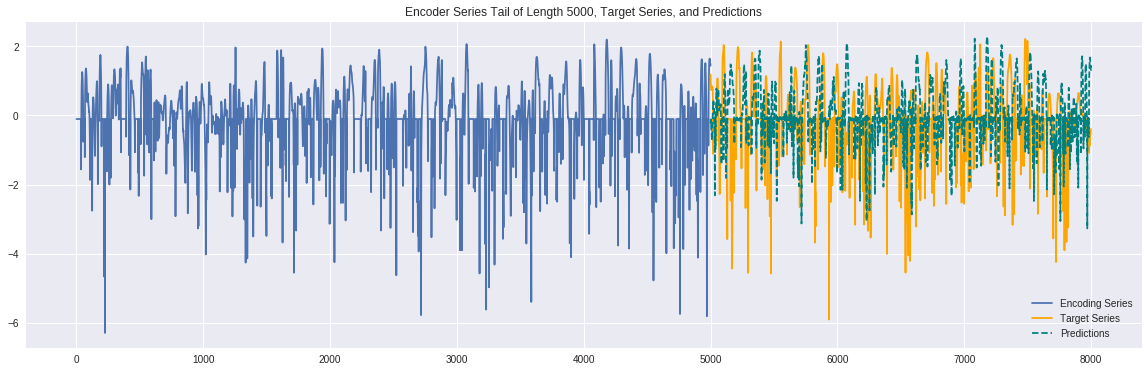

In [0]:
#MAKE PREDICTIONS

predictions(3, encoder_input_data_st_VAL, decoder_target_data_st_VAL, 5000)

Shape of all validation set predictions: (5, 3000, 1)
Predictions shape for index of interest: (3000, 1)
Actuals shape for index of interest: (3000, 1)


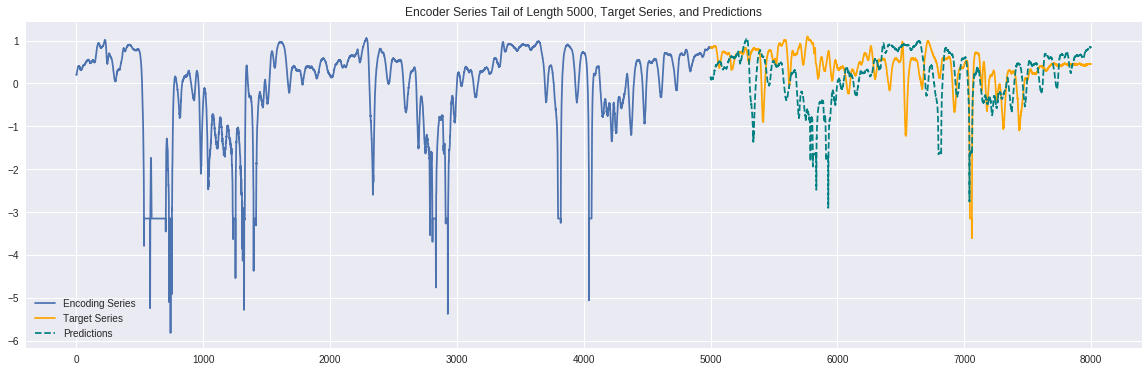

In [0]:
#MAKE PREDICTIONS

predictions(4, encoder_input_data_st_VAL, decoder_target_data_st_VAL, 5000)

<font color=#ff0000><b>//end here</font></b>

In [0]:
#I'm going to do this my own way b/c I dont' understand the function he wrote

#validation x set
validation_set_predictions = model.predict(encoder_input_data)
print("Shape of all validation set predictions:", validation_set_predictions.shape)



#validation y set - the ground truth 
print("Shape of all validation_y:", decoder_target_data.shape)

Shape of all validation set predictions: (5, 3000, 1)
Shape of all validation_y: (5, 3000, 1)


In [0]:
list(decoder_target_data[2])

[array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.40169244]),
 array([0.

In [0]:
validation_set_predictions

array([[[ 2.6744790e-04],
        [ 2.6744790e-04],
        [ 2.6744790e-04],
        ...,
        [ 1.8082359e-03],
        [ 1.7511128e-03],
        [ 1.7644456e-03]],

       [[ 1.0099705e+00],
        [ 6.3621253e-01],
        [ 6.2063920e-01],
        ...,
        [ 2.6446468e-01],
        [ 2.3467991e-01],
        [ 1.3523169e-01]],

       [[ 1.2376750e+00],
        [ 7.3320633e-01],
        [ 3.6806518e-01],
        ...,
        [ 3.3033875e-01],
        [ 3.5866812e-01],
        [ 4.2647123e-01]],

       [[ 1.2379628e+00],
        [ 1.4221065e+00],
        [ 1.5364014e+00],
        ...,
        [-6.5314099e-02],
        [-9.2490368e-02],
        [-3.7443671e-02]],

       [[ 1.3742011e+00],
        [ 1.2952625e+00],
        [ 1.4998914e+00],
        ...,
        [ 2.7927167e+00],
        [ 2.7948353e+00],
        [ 2.8026633e+00]]], dtype=float32)

In [0]:
#experiment on an index of interest 

pred_val_idx0 = validation_set_predictions[0, :, :]
pred_val_idx0
print(pred_val_idx0.shape)

(3000, 1)


In [0]:
truth_val_idx0 = decoder_target_data[0, :]
truth_val_idx0 = np.reshape(truth_val_idx0, (len(truth_val_idx0),-1))
print(truth_val_idx0.shape)

(3000, 1)


In [0]:
truth_val_idx0

array([[0.00356719],
       [0.00356719],
       [0.00356719],
       ...,
       [0.00356719],
       [0.00356719],
       [0.00356719]])

In [0]:
pred_val_idx0

array([[0.00026745],
       [0.00026745],
       [0.00026745],
       ...,
       [0.00180824],
       [0.00175111],
       [0.00176445]], dtype=float32)

Ok, we have the val_x set which is (5, 16341, 1). 

We want to predict on this set. 

The model wasn't trained on a dataset of the same dimension. The 'encoder_input_data' after teaching forcing, our train_x was (5, 19341, 1). 

so we ran `model.predict(encoder_input_data)`

This outputted `validation_set_predictions` which are of shape (5, 3000, 1)






In [0]:
ix = 2 #2 is accel2 sensor

pred_val_idx = validation_set_predictions[ix, :, :]
pred_val_idx
print("Predictions shape:", pred_val_idx.shape)

truth_val_idx = decoder_target_data[ix, :]
truth_val_idx = np.reshape(truth_val_idx, (len(truth_val_idx),-1))
print("Truth shape:", truth_val_idx.shape)


print(pred_val_idx)
print(truth_val_idx)

Predictions shape: (3000, 1)
Truth shape: (3000, 1)
[[1.237675  ]
 [0.73320633]
 [0.36806518]
 ...
 [0.33033875]
 [0.35866812]
 [0.42647123]]
[[0.40169244]
 [0.40169244]
 [0.40169244]
 ...
 [0.40169244]
 [0.40169244]
 [0.40169244]]


In [0]:
(encoder_input_data[ix, :, :]).shape

(16343, 1)

In [0]:
#get the last 1000 timesteps of the validation x set (black) for the index of interest
tail = 1000

last_x_steps = (encoder_input_data[ix, :, :])[-tail:]

#get the validation predictions (--red) for the index of interest
preds = pred_val_idx

#get the validation truth (green) for the index of interest
truth = truth_val_idx

In [0]:
last_x_steps.shape

In [0]:
last_x_steps

In [0]:
foo[:1000]

In [0]:
x_encode = foo.shape[0]
print(x_encode)

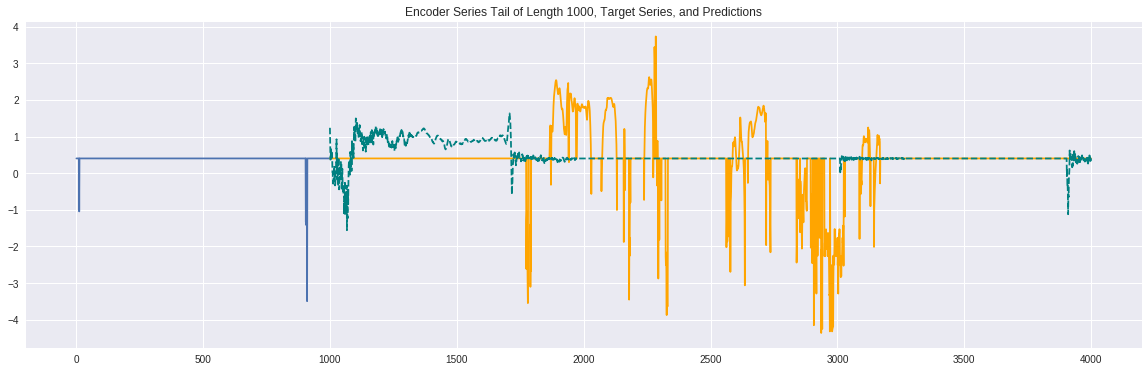

In [0]:
#plot it


plt.figure(figsize=(20,6))   
    
#plt.plot(foo[1000:], color='black')
#plt.plot(foo[-3000:],color='orange')
#plt.plot(preds,color='teal',linestyle='--')
    
plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % tail)
plt.legend(['Encoding Series','Target Series','Predictions'])

#(1, tail) = (1, 1000)
#(1, 4001)

plt.plot(range(1,tail+1),last_x_steps)
plt.plot(range(tail,tail+3000),truth,color='orange') #(1000, 4000)
plt.plot(range(tail,tail+3000),preds,color='teal',linestyle='--')
